# 欧洲看涨期权定价 Pricing European Call Options

### 介绍 Introduction

###### 行权价（K）、到期时间（T）、股价（S）、股价的波动率（Sigma）、无风险收益率（r）

###### 假设有一个执行价格为K的欧洲看涨期权，其标的资产在到期时的现货价格$S_T$遵循一个给定的随机分布。对应的收益函数定义为:

<center>$ max\begin{Bmatrix}S_T−K,0\end{Bmatrix}$</center>

###### 下面，我们使用基于振幅估计的量子算法来估计期权的预期收益。例，折现前的公平价格:

<center>$ \mathbb{E}\begin{bmatrix}max\begin{Bmatrix}S_T−K,0\end{Bmatrix}\end{bmatrix}$</center>

###### 以及对冲值Δ。例，期权价格相对于现货价格的导数，其定义为:

<center>$ \Delta=P\begin{bmatrix}S_T−K \geq K\end{bmatrix}$</center>

###### 下面的文章给出了目标函数的近似和量子计算机期权定价与风险分析的一般介绍:

- Quantum Risk Analysis. Woerner, Egger. 2018.
- Option Pricing using Quantum Computers. Stamatopoulos et al. 2019.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumCircuit
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.circuit.library import LogNormalDistribution, LinearAmplitudeFunction, NormalDistribution

In [2]:
circuit = NormalDistribution(3, mu=1, sigma=1, bounds=(0, 2))
circuit.draw()

<ipython-input-2-5eac025b486a>:1: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.
  circuit = NormalDistribution(3, mu=1, sigma=1, bounds=(0, 2))


┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1 P(X) ├
     │       │
q_2: ┤2      ├
     └───────┘

### 不确定性模型 Uncertainty Model

###### 我们构造了一个把对数正态分布加载进量子态的电路。分布被截断到一个给定的区间[low，high]，并使用$2^n$个网格点进行离散操作，其中n表示使用的量子位元的数量。电路对应的酉算子实现如下:

<center>$|0⟩_n \Rightarrow |\psi⟩_n = \sum_{i=0}^{2^n-1}\sqrt{p_i}|i⟩_n$</center>
    
###### 其中 $p_i$ 表示截短离散分布对应的概率，其中 $i$ 使用仿射映射到正确的区间:

<center>$ \begin{Bmatrix}0,\cdots,2^n-1\end{Bmatrix}∋ i \Rightarrow \frac{high-low}{2^n-1} \times i + low \in \begin{bmatrix}low,high\end{bmatrix} $</center>


In [35]:
# 表示不确定性的量子位的数量
num_uncertainty_qubits = 3

# 相对随机分布的参数
S = 42.881       # 最初的现货价格
vol = 0.03     # 40%的波动
r = 0.05      # 无风险利率年化为5%
T = 40 / 365  # 40天到期

# 得到的参数为对数正态分布
mu = ((r - 0.5 * vol**2) * T + np.log(S))                     # 平均值
sigma = vol * np.sqrt(T)                                      # 波动率
mean = np.exp(mu + sigma**2/2)                                # 期望值 见下方markdown
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)   # 方差 一组数据内部的离散程度
stddev = np.sqrt(variance)                                    # 标准差

# 考虑现货价格的最低和最高价值;在中间，考虑等距离散化。
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# 构造一个用于QAE的操作符
# 组成不确定性模型和目标
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

<ipython-input-35-ca26d0ec3f6d>:23: DeprecationWarning: `LogNormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.LogNormalDistribution.
  uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))


已知$X~(\mu, \sigma^2)$,则
<center>$\mathbb{E}(e^X) = e^{\mu+\frac{\sigma^2}{2}}$</center>
<center>$Var = (e^{\sigma^2}-1) \times e^{2\mu + \sigma^2}$</center>

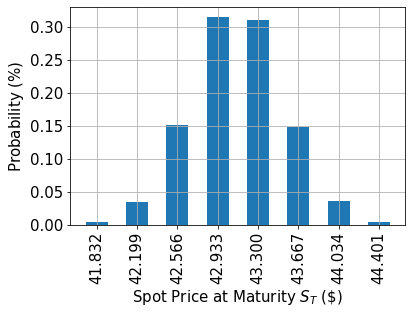

In [36]:
# 画出概率分布
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

### 支付函数 Payoff Function
###### 只要到期$S_T$的现货价格小于执行价格K，收益函数就等于零，然后线性增加。该实现使用一个比较器，如果$S_T≥K$，该比较器将一个辅助量子位从$∣0⟩$翻转到$∣1⟩$，并且该辅助器用于控制收益函数的线性部分。

###### 然后将线性部分本身近似如下。对于小的|y|，利用 $\sin^2(y+\frac{\pi}{4})≈y+\frac{1}{2}$ 这一事实。因此，对于给定的近似缩放因子$c_{approx}\in[0,1]$和$x\in[0,1]$，尤其小型 $c_{approx}$,我们考虑

<center>$\sin^2 (\frac{\pi}{2} * c_{approx} * (x - \frac{1}{2}) + \frac{\pi}{4}) \approx \frac{\pi}{2} * c_{approx} * (x - \frac{1}{2}) + \frac{1}{2}$</center>

###### 我们可以很容易地利用y旋转控制构造一个操作符来充当

<center>$|x⟩|0⟩ \Rightarrow |x⟩ (\cos(a * x + b)|0⟩ + \sin(a * x + b)|1⟩)$</center>

###### 最终，我们感兴趣的是在最后一个量子位中测量 $∣1⟩$ 的概率，它对应于 $sin^2(a∗x+b)$ 。连同上面的近似，这允许近似感兴趣的值。我们选择的 $c_{approx}$ 越小，逼近效果越好。然而，由于我们正在估计一个由 $c_{approx}$ 缩放的属性，因此需要相应地调整评估量子位元 $m$ 的数量。

###### 关于近似的更多细节，请参阅:Quantum Risk Analysis. Woerner, Egger. 2018.

In [5]:
# 设定执行价格(应在不确定性的低值和高值范围内)
strike_price = 1.896

# 设置支付函数的近似缩放
c_approx = 0.25
# 建立分段线性目标函数
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx
)

# 为支付函数构造一个QAE算子
# 组成不确定性模型和目标
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

┌───────┐┌────┐
q_0: ┤0      ├┤0   ├
     │       ││    │
q_1: ┤1 P(X) ├┤1   ├
     │       ││    │
q_2: ┤2      ├┤2   ├
     └───────┘│    │
q_3: ─────────┤3 F ├
              │    │
q_4: ─────────┤4   ├
              │    │
q_5: ─────────┤5   ├
              │    │
q_6: ─────────┤6   ├
              └────┘

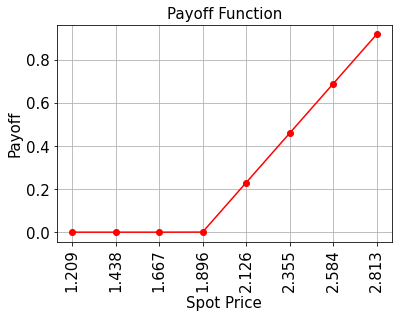

In [6]:
# 绘制精确的支付函数(在不确定性模型的网格上进行评估)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [7]:
# 计算精确的期望值(归一化到[0,1]区间)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print('exact expected value:\t%.4f' % exact_value)
print('exact delta value:   \t%.4f' % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


### Evaluate Expected Payoff

In [15]:
# 设定目标精度和置信度
epsilon = 0.01
alpha = 0.05

# 构造幅度估计
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_call,
                                  objective_qubits=[3],
                                  post_processing=european_call_objective.post_processing)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=1000)
conf_int = np.array(result['confidence_interval'])
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1654
Confidence interval:	[0.1579, 0.1728]


###### 与手工构造这些电路不同，Qiskit的财务模块提供了$EuropeanCallExpectedValue$ 电路，它已经作为构建块实现了这一功能。

In [23]:
from qiskit.finance.applications import EuropeanCallExpectedValue

european_call_objective = EuropeanCallExpectedValue(num_uncertainty_qubits,
                                                    strike_price,
                                                    rescaling_factor=c_approx,
                                                    bounds=(low, high))

# 将不确定性模型附加到前面
european_call = european_call_objective.compose(uncertainty_model, front=True)
european_call.draw()

┌───────┐┌────┐
q739_0: ┤0      ├┤0   ├
        │       ││    │
q739_1: ┤1 P(X) ├┤1   ├
        │       ││    │
q739_2: ┤2      ├┤2   ├
        └───────┘│    │
q740_0: ─────────┤3 F ├
                 │    │
 a10_0: ─────────┤4   ├
                 │    │
 a10_1: ─────────┤5   ├
                 │    │
 a10_2: ─────────┤6   ├
                 └────┘

In [20]:
# 设定目标精度和置信度
epsilon = 0.01
alpha = 0.05

# 构造幅度估计
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_call,
                                  objective_qubits=[3],
                                  post_processing=european_call_objective.post_processing)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=1000)

conf_int = np.array(result['confidence_interval'])
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1697
Confidence interval:	[0.1623, 0.1772]


### Evaluate Delta
#### Delta比预期收益更容易计算。类似于预期的回报，我们使用比较电路和辅助量子位来识别$S_T>K$的情况。然而，由于我们只对这个条件为真的概率感兴趣，我们可以直接使用这个辅助量子位作为振幅估计的客观量子位，而无需进一步的近似。

In [24]:
from qiskit.finance.applications import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(num_uncertainty_qubits, strike_price, bounds=(low, high))

european_call_delta.decompose().draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │  cmp │
state_3: ┤3     ├
         │      │
 work_0: ┤4     ├
         │      │
 work_1: ┤5     ├
         └──────┘

In [25]:
state_preparation = QuantumCircuit(european_call_delta.num_qubits)
state_preparation.append(uncertainty_model, range(uncertainty_model.num_qubits))
state_preparation.append(european_call_delta, range(european_call_delta.num_qubits))
state_preparation.draw()

┌───────┐┌──────┐
q_0: ┤0      ├┤0     ├
     │       ││      │
q_1: ┤1 P(X) ├┤1     ├
     │       ││      │
q_2: ┤2      ├┤2     ├
     └───────┘│  ECD │
q_3: ─────────┤3     ├
              │      │
q_4: ─────────┤4     ├
              │      │
q_5: ─────────┤5     ├
              └──────┘

In [26]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                        state_preparation=state_preparation,
                                        objective_qubits=[num_uncertainty_qubits])

In [27]:
result_delta = ae_delta.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [28]:
conf_int = np.array(result_delta['confidence_interval'])
print('Exact delta:    \t%.4f' % exact_delta)
print('Esimated value: \t%.4f' % result_delta['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Exact delta:    	0.8098
Esimated value: 	0.8067
Confidence interval: 	[0.8009, 0.8124]


In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyrightw